In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('seaborn')
import pandas_profiling
import seaborn as sns
%matplotlib inline

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Path shortcut to files
path = '/content/drive/My Drive/GITHUB REPO/Walmart_forecasting_ML'

In [69]:
features = pd.read_csv(f"{path}/walmart_data/features.csv")
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [70]:
stores = pd.read_csv(f"{path}/walmart_data/stores.csv")
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [71]:
main_set = pd.read_csv(f"{path}/walmart_data/train.csv")
main_set.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [72]:
print("Features set:",len(features))
print("Stores set:",len(stores))
print("Main set:", len(main_set))

Features set: 8190
Stores set: 45
Main set: 421570


In [73]:
# The final testing set
pd.read_csv(f"{path}/walmart_data/test.csv").head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


We have to merge with 'stores and features' data frames to get more attributes

### **Merging the full dataset (main_set)**

In [74]:
# merge with stores dataframe
main_set = main_set.merge(stores, how='left', on='Store')
main_set.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


In [75]:
# merge with features dataframe
main_set = main_set.merge(features, how='left')
main_set.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


### **Split train/test data**

* train set > 2010-02-05 to 2011-12-31
* test_set > 2012-01-01 to 2012-11-01

In [76]:
train_set = main_set[main_set['Date']<='2011-12-31']
train_set.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [77]:
test_set = main_set[main_set['Date']>'2011-12-31']
test_set.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
100,1,1,2012-01-06,16567.69,False,A,151315,49.01,3.157,6277.39,21813.16,143.10,1450.13,8483.00,219.714258,7.348
101,1,1,2012-01-13,16894.40,False,A,151315,48.53,3.261,5183.29,8025.87,42.24,453.08,3719.38,219.892526,7.348
102,1,1,2012-01-20,18365.10,False,A,151315,54.11,3.268,4139.87,2807.19,33.88,500.62,3400.21,219.985689,7.348
103,1,1,2012-01-27,18378.16,False,A,151315,54.26,3.290,1164.46,1082.74,44.00,11.00,1222.19,220.078852,7.348
104,1,1,2012-02-03,23510.49,False,A,151315,56.55,3.360,34577.06,3579.21,160.53,32403.87,5630.40,220.172015,7.348


train/test ratio: ~70/30

In [78]:
print("Train Ratio Set:", f"{round((len(train_set) / len(main_set) * 100), 4)}%")
print("Test Ratio Set:", f"{round((len(test_set) / len(main_set) * 100), 4)}%")

Train Ratio Set: 69.7706%
Test Ratio Set: 30.2294%


## **Exploratory Data Analysis**

We have to decide how correlate are the attributes and how they affect the target value. Furthermore, we have to decide wich attributes to use in the model and the ones we should drop.

In [79]:
# Get a report of actual train set
train_report = pandas_profiling.ProfileReport(train_set)
train_report.to_file(outputfile=f"{path}/trainSet_report.html")

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


<div class="col-md-12" style="padding-left: 1em;">
	<p class="h4">Warnings</p>
	<ul class="list-unstyled">
		<li>
			<a href="#pp_var_Date">
				<code>Date</code>
			</a> has a high cardinality: 100 distinct values  
			<span class="label label-warning">Warning</span>
		</li>
		<li>
			<a href="#pp_var_MarkDown1">
				<code>MarkDown1</code>
			</a> has 270432 / 91.9% missing values 
			<span class="label label-default">Missing</span>
		</li>
		<li>
			<a href="#pp_var_MarkDown2">
				<code>MarkDown2</code>
			</a> has 273978 / 93.1% missing values 
			<span class="label label-default">Missing</span>
		</li>
		<li>
			<a href="#pp_var_MarkDown3">
				<code>MarkDown3</code>
			</a> has 271016 / 92.1% missing values 
			<span class="label label-default">Missing</span>
		</li>
		<li>
			<a href="#pp_var_MarkDown4">
				<code>MarkDown4</code>
			</a> has 273090 / 92.8% missing values 
			<span class="label label-default">Missing</span>
		</li>
		<li>
			<a href="#pp_var_MarkDown5">
				<code>MarkDown5</code>
			</a> has 270138 / 91.8% missing values 
			<span class="label label-default">Missing</span>
		</li>
		<li>
			<a href="#pp_var_Store">
				<code>Store</code>
			</a> is highly correlated with 
			<a href="#pp_var_index">
				<code>index</code>
			</a> (ρ = 0.9992) 
			<span class="label label-primary">Rejected</span>
		</li>
	</ul>
</div>

**About report Warnings**

* Date: Not droppable

* MarkDown: Since the missing values are in range (91.8% - 93.1%) we could drop those attributes. But this MarkDowns are data relational about promotions in diferents stores. So we will fill missing data with 0 insted.

* Store: The number of the store, is a categorical value

#### **Store**

The store number

In [80]:
# 45 differents stores
np.unique(train_set["Store"].unique(), return_counts=True)[1].sum()

45

#### **Dept**

#### **Date**

<Figure size 700x300 with 0 Axes>

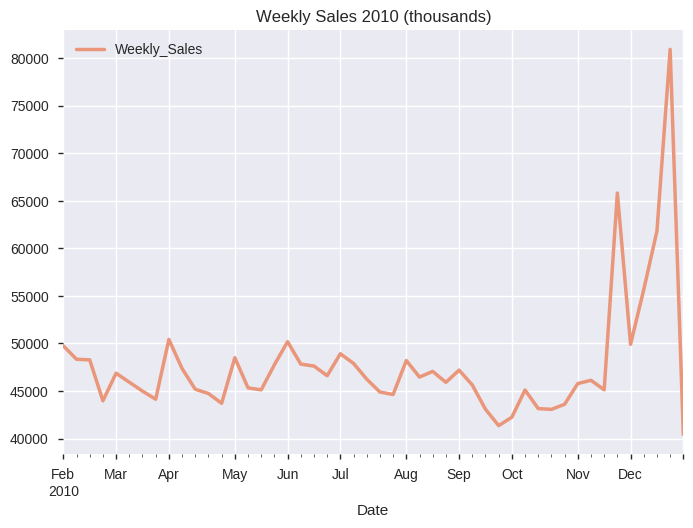

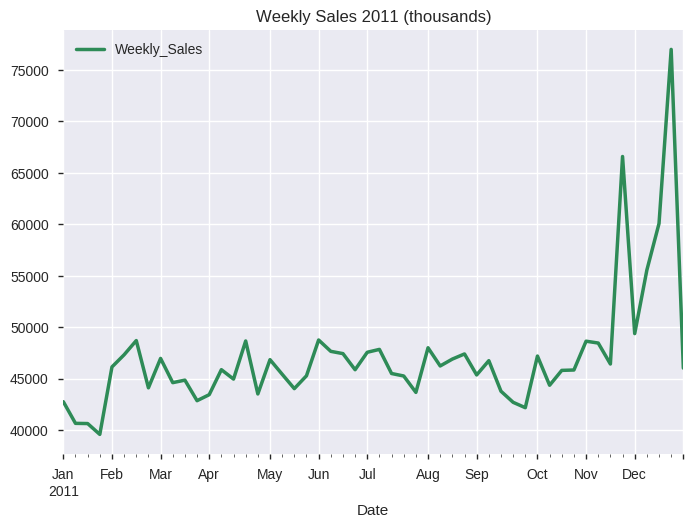

In [113]:
data = train_set[["Date", "Weekly_Sales"]].groupby(by=["Date"]).sum().reset_index()
data["Date"] = pd.to_datetime(data["Date"])
data["Weekly_Sales"] = data['Weekly_Sales'] / 1000

data_2010 = data[data['Date']<"2011"]
data_2011 = data[data["Date"] >= "2011"]
fig = plt.figure(figsize=(7, 3))
data_2010.plot(x='Date', y="Weekly_Sales", kind="line", color="darksalmon", linewidth=2.5, title="Weekly Sales 2010 (thousands)")
data_2011.plot(x='Date', y="Weekly_Sales", kind="line", color="seagreen", linewidth=2.5, title="Weekly Sales 2011 (thousands)")